In [44]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(16, 4.2)

from util import util_dr as util
from matplotlib import pyplot as plt
import numpy as np
from tensorflow import keras
from sklearn.metrics import accuracy_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Digit Recognition

### Problem and Data

## Digit Recognition

**We'll consider a simple digit recognition problem**

<center>
<img src="assets/mnist.png" width=55%/>
</center>

* Given an image representing a digit, we need to recognition the represented number
* This is an important building block for most OCR systems

## The Dataset

**We will use the classic [MNIST Digit Recognition Dataset](http://yann.lecun.com/exdb/mnist/) dataset**

The dataset contains hand-written digits

* The original data was obtain from US Census Bureau and high-schools students
* Each digit is represented as a $28 \times 28$ greyscale image

In [22]:
from keras.datasets import mnist
# load the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

The MNIST data is now stored in pairs of numpy arrays.

* The `x_train` and `x_test` arrays contain the greyscale value of each pixel
* The `y_train` and `y_test` arrays contain the class (digit) as an integer

## Image Data

**Let's inspect the output**

In [23]:
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_test: {y_test.shape}')
n_tr = y_train.shape[0]
n_ts = y_test.shape[0]

Shape of y_train: (60000,)
Shape of y_test: (10000,)


* There are 60,000 training examples
* ...And 10,000 test examples

**The target arrays are one-dimensional**

Let's check a sample:

In [24]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

## Image Data

**Let's inspect the input**

In [25]:
print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_test: {x_test.shape}')
x_h = x_train.shape[1]
x_w = x_train.shape[2]

Shape of x_train: (60000, 28, 28)
Shape of x_test: (10000, 28, 28)


* The dataset input consists of 28x28 matrices

In [26]:
print(f'Minimum: {x_train.min()} (train), {x_train.min()} (test)')
print(f'Maximum: {x_train.max()} (train), {x_train.max()} (test)')

Minimum: 0 (train), 0 (test)
Maximum: 255 (train), 255 (test)


* The content of the matrix cells ranges from 0 to 255
* ...And it represents 8 bit brightness values

## Image Data

**Let's see some sample images**

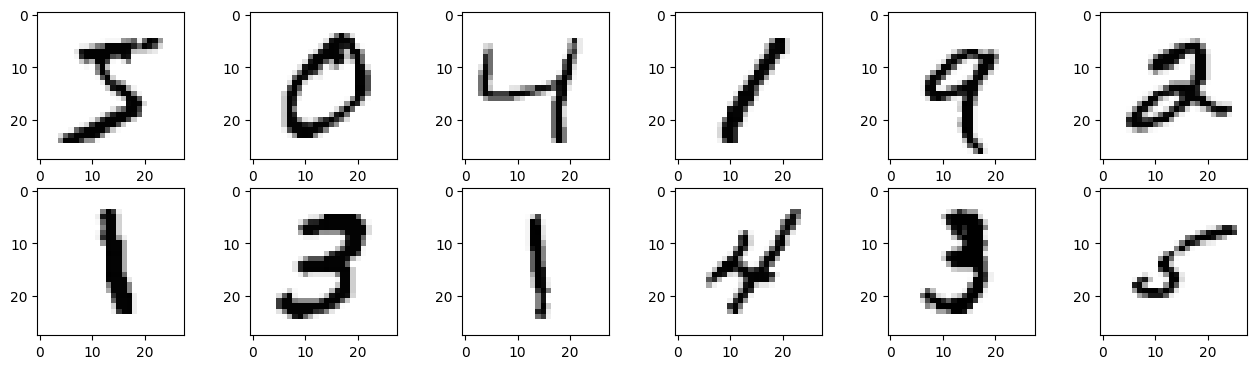

In [27]:
m, n = 2, 6
plt.figure(figsize=figsize)
for i in range(m):
    for j in range(n):
        plt.subplot(m, n, i*n + j + 1)
        plt.imshow(x_train[i*n + j], cmap='Greys')
plt.show()

# Digit Recognition

### A Solution Approach

## Problem Model

**This is a standard classification problem**

...But it still best modeled in a probabilistic fashion

* We can view the image as a random (vector) variable $X$
* ...And the class a second random variable $Y$, with values in $\{c_1, c_2, \ldots c_{n}\}$

This the case for multiple reasons (e.g. labeling errors or ambiguous interpretation)

**The two variables are correlated, which is captured via their joint distribution**

$$X, Y \sim P(X, Y)$$

...But in practice, we are assuming $X$ is observed, so we care about the conditional distribution:

$$P(Y \mid X)$$

## Problem Model

**We will approximate the $P(Y \mid X)$ via a parameterized function $\hat{f}(y, x; \theta)$**

...Which we can train via Maximum Likelihood Estimation

* Given a training dataset $\{x_i, y_i\}_{i=1}^m$, we solve:

$$\mathop{\rm argmax}_{\theta} \prod_{i=1}^m \sum_{j=1}^n [\![ y_i = c_j]\!] \hat{f}(c_j, x; \theta)$$

* Where $[\![ y_i = c_j]\!] = 1$ iff $y_i = c_j$
* ...And $\hat{f}(c_j, x; \theta)$ is the estimate probability of value $c_j$

**From the probability estimator, we can obtain a classifier**

* We simply look for the value (i.e. the class) in $\{c_1, \ldots c_n\}$
* ...That is associated to the largest probability

## Neural Network Classifiers

**We will rely on a Neural Network for our approximate model**

NNs that are used for classification have a typical structure

<center><img src="assets/ann.png" width=50%></center>

* Their output layer has one neuron for each possible class
* ...And it uses a [softmax](https://en.wikipedia.org/wiki/Softmax_function) activation function to ensure the output sum up to 1

**By doing this, the output can be interpreted a discrete probability distribution**

## Preprocessing

**Before we can start training we need to do some preprocessing**

We will apply a _min-max encoding to the input_

* ...Since there is clear minimum and maximum for each pixel

In [28]:
x_train_norm = x_train / 255.0
x_test_norm = x_test / 255.0

We will adopt a _one-hot encoding for the output_

* ...Since we will need to build a network with one neuron per class

In [29]:
y_train_cat = keras.utils.to_categorical(y_train)
y_test_cat = keras.utils.to_categorical(y_test)
y_train_cat[:2, :]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

## Adding Channel Information

**When working with image data, one extra step is needed**

...Since images are not necessarily greyscale!

* Greyscale images can be represented as matrices
* ...But color images have a value of red, green, and blue for each pixel!

For this reason, an image is best described by a _tensor_ not a matrix

**Even if we have a single channel, it will be best to convert each input to a tensor**

In [31]:
x_train_c = x_train_norm.reshape(-1, x_h, x_w, 1)
x_test_c = x_test_norm.reshape(-1, x_h, x_w, 1)
input_shape = (x_h, x_w, 1)
output_shape = (10,)
print(f'New shape of the training set: {x_train_c.shape}')

New shape of the training set: (60000, 28, 28, 1)


## Training a Baseline Model

**As a baseline, we will build an MLP model**

We will have a look at the code, without going much into detail

```python
def build_mlp(input_shape, output_shape, hidden, rate=0.05):
    mdl = keras.Sequential()
    mdl.add(keras.Input(shape=input_shape))
    mdl.add(keras.layers.Flatten())
    for k, h in enumerate(hidden):
        mdl.add(Dense(h, activation='relu'))
        mdl.add(keras.layers.Dropout(rate))
    mdl.add(Dense(output_shape[0], activation='softmax'))
    return mdl
```

...Even if a classical MLP is not designed to handle images

* For this reason we'll start with a special `Flatten` layer
* Notice the use of a softmax in the output layer

## Training a Baseline Model

**We can now train a 2-layer network as a baseline**

In [40]:
nn1 = util.build_mlp(input_shape, output_shape, hidden=[16, 16])
history = util.train_nn(nn1, x_train_c, y_train_cat, batch_size=32, epochs=30, verbose=1)

Epoch 1/30
1875/1875 [==============================] - 2s 862us/step - loss: 0.6205
Epoch 2/30
1875/1875 [==============================] - 2s 847us/step - loss: 0.3441
Epoch 3/30
1875/1875 [==============================] - 2s 864us/step - loss: 0.3011
Epoch 4/30
1875/1875 [==============================] - 2s 846us/step - loss: 0.2778
Epoch 5/30
1875/1875 [==============================] - 2s 857us/step - loss: 0.2615
Epoch 6/30
1875/1875 [==============================] - 2s 852us/step - loss: 0.2521
Epoch 7/30
1875/1875 [==============================] - 2s 848us/step - loss: 0.2393
Epoch 8/30
1875/1875 [==============================] - 2s 844us/step - loss: 0.2341
Epoch 9/30
1875/1875 [==============================] - 2s 860us/step - loss: 0.2274
Epoch 10/30
1875/1875 [==============================] - 2s 894us/step - loss: 0.2214
Epoch 11/30
1875/1875 [==============================] - 2s 913us/step - loss: 0.2149
Epoch 12/30
1875/1875 [==============================] - 2s 858

## Training a Baseline Model

**Let's inspect the training curve**

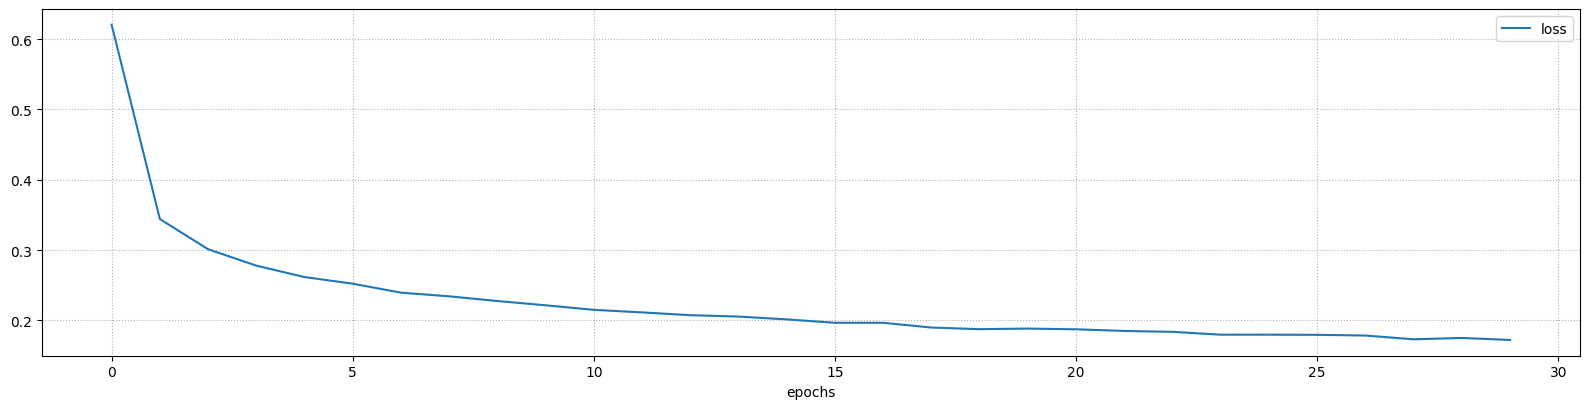

Final loss: 0.1721 (training)


In [41]:
util.plot_training_history(history, figsize=figsize)

There's still something to go before convergence, but we'll stop here

## Evaluation

**Now we can compute the model accuracy**

In [45]:
nn1_p_tr = nn1.predict(x_train_c, verbose=0).argmax(axis=1)
nn1_p_ts = nn1.predict(x_test_c, verbose=0).argmax(axis=1)

nn1_acc_tr = accuracy_score(y_train, nn1_p_tr)
nn1_acc_ts = accuracy_score(y_test, nn1_p_ts)

print(f'2-layer network accuracy: {nn1_acc_tr:.3f} (train), {nn1_acc_ts:.3f} (test)')

2-layer network accuracy: 0.968 (train), 0.952 (test)


We are doing already pretty well!

> **What can we do to improve the results?**<br>Beyond "stacking more layers" the answer is not clear

# Digit Recognition

### Convolutional Neural Networks

## Exploiting Structural Information

**DNs are very flexible learning models**

* ...Since we can choose both how many layer to use
* ...And how big they should be

**However, it's difficult to develop an intuition of which options work**

* This is due to the poor interpretability of DNs
* ...To the point that a [fully fledged research field](https://en.wikipedia.org/wiki/Automated_machine_learning) focuses on automatic tuning

**There is one type of choice that is intuitive and has a big impact**

...This concerns the idea of exploiting structural information

* For example, nearby pixels in an image may be semantically linked
* ...And the same goes for nearby points in time
* ...Or nearby words in a sentence

## Convolutional Layers

**This idea is at the basis of _convolutional layers_**

A 2D convolution layer...

* Starts from an input tensor with shape $(m, n, c)$
* ...And slides a linear $n_f, m_f$ filter (or kernel) on top of the image, with a certain step size (stride)

<center>
<img src="assets/pooling.png" width=50%/>
</center>

* You can think of that as moving an $n_f, m_f$ mask across an image
* The figure shows a 2x2 convolution with stride 2

## Convolutional Layers

**Each application of the kernel...**

* Computes a dot product (involving all channels) to obtain a scalar
* ...The optionally applies an activation function

Here we see the effect along 1 dimension:

<center>
<img src="assets/convstack0.png" width=60%/>
</center>

**Therefore, by applying a 2D convolution to an input tensor**

...We get a slightly smaller output tensor (like smaller image)

* Every kernel we apply builds a new "channel" in the output

## Convolutional Layers

**Convolutional layers have some interesting properties**

Their weights are associated _only to the filter_

* So, all applications of the filter/kernel use the same weights
* ...And the number weights does not depend on the input size

This allows a _huge_ reduction in terms of number of weights

**Of course the model will be _less expressive_**

...But still capable of laerning useful relations!

* Intuitively, filters will learn to recognize _local features_
* Earlier convolutions will focus on fine-grain details
* ...While later convolution will aggregate them

**This property allows CNN to work very well on image data** 

## CNNs in Keras

**We'll glance again at the code to build a Convolutional NN (in Tensorflow/Keras)**

```python
def build_cnn(input_shape, output_shape, hidden, convs, rate=0.05):
    mdl = keras.Sequential()
    mdl.add(keras.Input(shape=input_shape))
    for nf in convs:
        mdl.add(Conv2D(nf, kernel_size=(3,3), activation='relu'))
    mdl.add(keras.layers.Flatten())
    for h in hidden:
        mdl.add(Dense(h, activation='relu'))
        mdl.add(keras.layers.Dropout(rate))
    mdl.add(Dense(output_shape[0], activation='softmax'))
    return mdl
```

* We start by building the convolutions layer
* ...Then we add some fully connected layers
* ...And we finish with an output layer using a softmax activation

## Training a CNN

**CNNs can be trained as usual, but the process is much slower**

...Since even with few weights, we still need to do a lot of computations

* Using GPUs can considerably accelerate this step

In [46]:
cnn1 = util.build_cnn(input_shape, output_shape, hidden=[16], convs=[16])
history2 = util.train_nn(cnn1, x_train_c, y_train_cat, batch_size=32, epochs=30, verbose=1)

Epoch 1/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2761
Epoch 2/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1133
Epoch 3/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0889
Epoch 4/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0750
Epoch 5/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0653
Epoch 6/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0566
Epoch 7/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0500
Epoch 8/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0441
Epoch 9/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0400
Epoch 10/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0344
Epoch 11/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0320
Epoch 12/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0278
E

## Training a CNN

**Let's check the training curve**

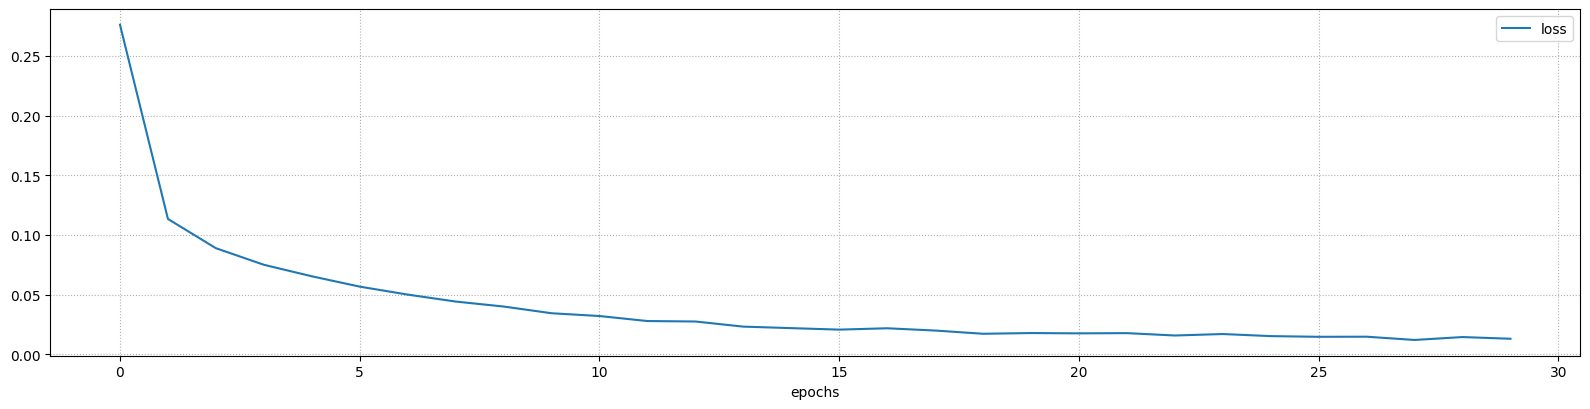

Final loss: 0.0130 (training)


In [48]:
util.plot_training_history(history2, figsize=figsize)

Again, there is still some way to go, but we'll stop here for a fair comparison

## Quality Evaluation

In [49]:
cnn1_p_tr = cnn1.predict(x_train_c, verbose=0).argmax(axis=1)
cnn1_p_ts = cnn1.predict(x_test_c, verbose=0).argmax(axis=1)

cnn1_acc_tr = accuracy_score(y_train, cnn1_p_tr)
cnn1_acc_ts = accuracy_score(y_test, cnn1_p_ts)

print(f'Shallow network accuracy: {nn1_acc_tr:.3f} (train), {nn1_acc_ts:.3f} (test)')
print(f'Convolutional network accuracy: {cnn1_acc_tr:.3f} (train), {cnn1_acc_ts:.3f} (test)')

Shallow network accuracy: 0.968 (train), 0.952 (test)
Convolutional network accuracy: 0.999 (train), 0.980 (test)


The results are much better!

* Even if the CNN has much fewer weights than the fully connected one
* ...And the same number of hidden layers

**Exploiting structural information is a powerful idea in DL**